<a href="https://colab.research.google.com/github/JosuePerezValenzuela/Neuronal-Siamese-Network/blob/master/siames_oficial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
print(torch.cuda.is_available())

True


In [ ]:

# Creating some helper functions
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [ ]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform

    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        #We need to approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            while True:
                #Look untill the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                #Look untill a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))

    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [ ]:
!unzip caras.zip

Archive:  caras.zip
   creating: caras/
   creating: caras/Ades/
  inflating: caras/Ades/mascota11a.png  
  inflating: caras/Ades/mascota11b.png  
   creating: caras/Belinda/
  inflating: caras/Belinda/Belinda1.jpg  
  inflating: caras/Belinda/Belinda2.jpg  
   creating: caras/Bicho/
  inflating: caras/Bicho/Bicho1.jpg  
   creating: caras/Carlitos/
  inflating: caras/Carlitos/mascota24b.png  
   creating: caras/Chava/
  inflating: caras/Chava/Chava1.jpg  
  inflating: caras/Chava/mascota10dchava.png  
   creating: caras/Chica/
  inflating: caras/Chica/mascota6b.PNG  
   creating: caras/Dexter/
  inflating: caras/Dexter/mascota8a.png  
  inflating: caras/Dexter/mascota8b.png  
   creating: caras/Dukesa/
  inflating: caras/Dukesa/mascota13a.png  
   creating: caras/Electrodo/
  inflating: caras/Electrodo/electrodo2.jpg  
  inflating: caras/Electrodo/mascota5b.PNG  
   creating: caras/Esperanza/
  inflating: caras/Esperanza/mascota1d.png  
  inflating: caras/Esperanza/mascota1e.png  
   

In [ ]:
!unzip pruebas.zip

Archive:  pruebas.zip
   creating: pruebas/
   creating: pruebas/Otto/
  inflating: pruebas/Otto/mascota14a.png  
  inflating: pruebas/Otto/mascota14b.png  
  inflating: pruebas/Otto/mascota14c.png  
  inflating: pruebas/Otto/mascota14e.png  
   creating: pruebas/Porrotito/
  inflating: pruebas/Porrotito/mascota12a.png  
   creating: pruebas/Toti/
  inflating: pruebas/Toti/Toti1.jpg  


In [ ]:
!unzip anchor.zip

Archive:  anchor.zip
   creating: anchor/
  inflating: anchor/Toti1.jpg        


In [ ]:
%cd /content/anchor
!rm -r .ipynb_checkpoints/

/content/anchor


In [ ]:
# Load the training dataset
folder_dataset = datasets.ImageFolder(root="/content/caras")

In [ ]:
# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

# Initialize the network
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)

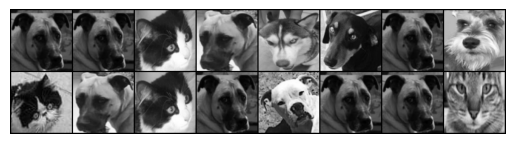

[1. 0. 0. 0. 1. 1. 0. 1.]


In [ ]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset,
                            shuffle=True,
                            num_workers=2,
                            batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

In [ ]:
#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),

            nn.Linear(256,2)
        )

    def forward_once(self, x):
        # This function will be called for both images
        # It's output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

In [ ]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidian distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [ ]:
# Load the training dataset
train_dataloader = DataLoader(siamese_dataset,
                              shuffle=True,
                              num_workers=8,
                              batch_size=64)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

Epoch number 0
 Current loss 2.0803070068359375

Epoch number 1
 Current loss 2.1269755363464355

Epoch number 2
 Current loss 1.8260759115219116

Epoch number 3
 Current loss 1.5423206090927124

Epoch number 4
 Current loss 1.4289820194244385

Epoch number 5
 Current loss 1.1710693836212158

Epoch number 6
 Current loss 0.7049607038497925

Epoch number 7
 Current loss 1.0598349571228027

Epoch number 8
 Current loss 0.5239903926849365

Epoch number 9
 Current loss 0.9144746661186218

Epoch number 10
 Current loss 0.8300430774688721

Epoch number 11
 Current loss 0.7057186961174011

Epoch number 12
 Current loss 0.8813372850418091

Epoch number 13
 Current loss 0.8145747184753418

Epoch number 14
 Current loss 0.6961204409599304

Epoch number 15
 Current loss 1.0238102674484253

Epoch number 16
 Current loss 0.7189311981201172

Epoch number 17
 Current loss 0.4124721884727478

Epoch number 18
 Current loss 0.6478463411331177

Epoch number 19
 Current loss 0.39899611473083496

Epoch num

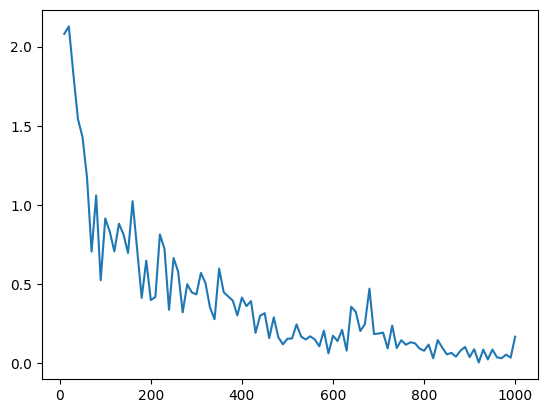

In [ ]:
counter = []
loss_history = []
iteration_number= 0

# Iterate throught the epochs
for epoch in range(100):

    # Iterate over batches
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Send the images and labels to CUDA
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter, loss_history)

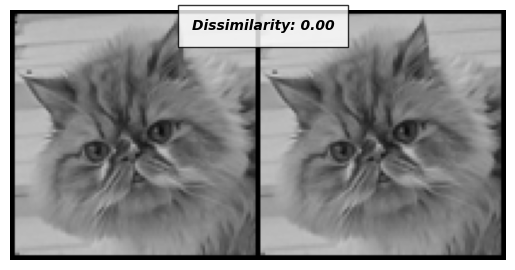

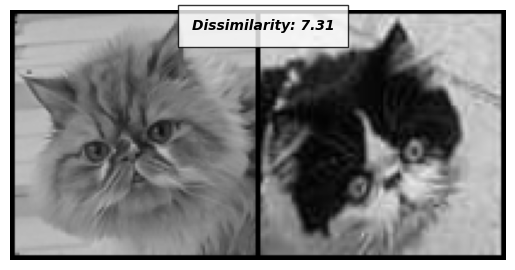

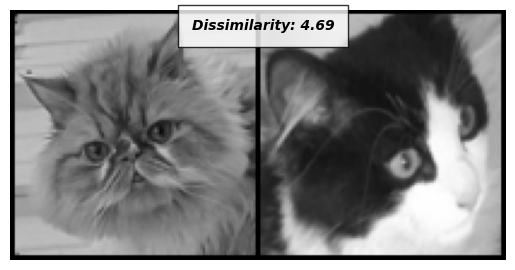

In [ ]:
# Locate the test dataset and load it into the SiameseNetworkDataset
folder_dataset_test = datasets.ImageFolder(root="/content/pruebas")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

folder_img_anchor = datasets.ImageFolder(root="/content/anchor")
anchor_transform = SiameseNetworkDataset(imageFolderDataset=folder_img_anchor,
                                        transform=transformation)
anchor_dataloader = DataLoader(anchor_transform, num_workers=2,batch_size=1)

anchor_iter = iter(anchor_dataloader)
anchor_image, _, _ = next(anchor_iter)


for i in range(3):
    dataiter = iter(test_dataloader)
    _, class_image, _ = next(dataiter)

    # Concatenate the two images together
    concatenated = torch.cat((anchor_image, class_image), 0)

    output1, output2 = net(anchor_image.cuda(), class_image.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')